# SOLUTION Wk18 Lecture02 CodeAlong: UFOs

## Learning Objectives

- By the end of this CodeAlong, students will be able to:
   - Calculate time series statistics (rolling mean/std/diff/pct_change
   - Perform feature engineering for time series EDA 
   - Aggregate time series using date parts to answer stakeholder questions.

    

# 🕹️Part 1) Preparing Irregular-Interval Time Series

### Overview from Last Lecture

- 1) [ ] Convert the dates & times to a single column (if needed).
- 2) [ ] Convert the datetime column  (most likely a string) to a datetime data type.
- 3) [ ] Set the datetime column as the Series/DataFrame index
- 4) [ ] Resample the time series to the desired/correct frequency using the desired/correct aggregation method.
- 5) [ ] Impute null values (if required)


### UFO Sightings

- UFO Sightings: https://www.kaggle.com/datasets/NUFORC/ufo-sightings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
ufo  = pd.read_csv("../Data/ufos-kaggle/scrubbed.csv", low_memory=False)
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556


In [3]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


>- 1) [x] Convert the dates & times to a single column (if needed).

## Preparing the Datetime Index

### Converting Date Cols to Datetime

In [4]:
try:
    ufo['datetime'] = pd.to_datetime(ufo["datetime"])
    display(ufo.head())
except Exception as e:
    display(e)

ParserError('hour must be in 0..23: 10/11/2006 24:00 present at position 388')

### Handling Errors with pd.to_datetime

- Can use the `errors` argument for pd.to_datetime:
    - "raise" (default): raise an exception when errors happen
    - 'ignore': ignores the errors and returns the original value for that row. 
        - NOT RECOMMENDED: the entire column will not be datetime.
    - 'coerce': convert any bad datetime values to null values (NaT - NotATime)

>- **Branch point: we have a choice on how we deal with the bad timestamps.**
    -  Do we coerce them, make then null values, and drop them? Potentially losing a lot of data.
    - Or do we investigate a bit more to see if we can fix the problem without losing data.
    
    
- Let's see how much data we would lose if we chose to coerce the bad values:

In [5]:
##check nulls before coercing errors
ufo.isna().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [6]:
## saving a copy of original datetime column
ufo['datetime-original'] = ufo['datetime'].copy()
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime-original
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,10/10/1949 20:30
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,10/10/1949 21:00
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,10/10/1955 17:00
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,10/10/1956 21:00
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,10/10/1960 20:00
...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,9/9/2013 21:15
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,9/9/2013 22:00
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,9/9/2013 22:00
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,9/9/2013 22:20


In [7]:
## Using errors = "coerce"
ufo["datetime-coerce"] = pd.to_datetime(ufo["datetime"], errors='coerce')
ufo["datetime-coerce"]

0       1949-10-10 20:30:00
1       1949-10-10 21:00:00
2       1955-10-10 17:00:00
3       1956-10-10 21:00:00
4       1960-10-10 20:00:00
                ...        
80327   2013-09-09 21:15:00
80328   2013-09-09 22:00:00
80329   2013-09-09 22:00:00
80330   2013-09-09 22:20:00
80331   2013-09-09 23:00:00
Name: datetime-coerce, Length: 80332, dtype: datetime64[ns]

In [8]:
## How many null values did we create?
ufo.isna().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
datetime-original          0
datetime-coerce          694
dtype: int64

In [9]:
## What % of dates became null?
ufo.isna().sum()/len(ufo)

datetime                0.000000
city                    0.000000
state                   0.072163
country                 0.120375
shape                   0.024050
duration (seconds)      0.000000
duration (hours/min)    0.000000
comments                0.000187
date posted             0.000000
latitude                0.000000
longitude               0.000000
datetime-original       0.000000
datetime-coerce         0.008639
dtype: float64

In [10]:
## inspecting just the bad rows
bad_rows = ufo[ufo['datetime-coerce'].isna()]
bad_rows

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime-original,datetime-coerce
388,10/11/2006 24:00,rome,ny,us,oval,120,a min or two,I was walking from the garage to the house&#44...,2/1/2007,43.2127778,-75.456111,10/11/2006 24:00,NaT
693,10/1/2001 24:00,chulucanas-piura la vieja (peru),NaN,NaN,other,6312000,2 years,go to: http://www.24horas.com.pe/data/videos/...,3/4/2003,-5.129547,-80.120569,10/1/2001 24:00,NaT
962,10/1/2012 24:00,novi,mi,us,triangle,300,5 minutes,V shaped and 8 big and very brite lights&#44mo...,10/30/2012,42.4805556,-83.475556,10/1/2012 24:00,NaT
1067,10/12/2003 24:00,salatiga (indonesia),NaN,NaN,disk,22,22 seconds,UFO in Salatiga&#44Indonesia,10/31/2003,-7.33683,110.498817,10/12/2003 24:00,NaT
1221,10/12/2013 24:00,cincinnati,oh,us,fireball,300,3-5 minutes,A bright orange light split into four&#44 did ...,10/14/2013,39.1619444,-84.456944,10/12/2013 24:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79136,9/4/2005 24:00,boonville,nc,us,cigar,10800,3+ hours,Unusual activity in our small community&#44 cr...,9/9/2013,36.2325000,-80.708333,9/4/2005 24:00,NaT
79137,9/4/2005 24:00,redondo beach,ca,us,triangle,300,5 minutes,Triangulat UFO seen over Redondo Beach&#44 Cal...,12/16/2005,33.8491667,-118.387500,9/4/2005 24:00,NaT
79740,9/7/2002 24:00,portsmouth,oh,us,changing,900,15 minutes,A bright red light hoovering in the sky.,9/13/2002,38.7316667,-82.997778,9/7/2002 24:00,NaT
79759,9/7/2004 24:00,montrose,co,us,unknown,1200,20 minutes,Stationary object with three pulsating lights ...,9/9/2004,38.4783333,-107.875556,9/7/2004 24:00,NaT


In [11]:
## let's try to convert the bad rows again
try:
    pd.to_datetime(bad_rows['datetime-original'])
except Exception as e:
    display(e)

ParserError('hour must be in 0..23: 10/11/2006 24:00 present at position 0')

> 🤔"`ParserError: hour must be in 0..23: 10/11/2006 24:00 present at position 0`"

In [12]:
bad_rows['datetime-original']

388      10/11/2006 24:00
693       10/1/2001 24:00
962       10/1/2012 24:00
1067     10/12/2003 24:00
1221     10/12/2013 24:00
               ...       
79136      9/4/2005 24:00
79137      9/4/2005 24:00
79740      9/7/2002 24:00
79759      9/7/2004 24:00
79942      9/8/2003 24:00
Name: datetime-original, Length: 694, dtype: object

> Panda's is confused by 24:00. It doesn't know if we mean 0:00 of the NEXT day or if we mean the 11:59 pm (23:59) the same day

In [13]:
## replace 24:00 with 23:59
ufo['datetime-fixed'] = ufo["datetime-original"].str.replace(" 24:00"," 23:59")
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime-original,datetime-coerce,datetime-fixed
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,10/10/1949 20:30,1949-10-10 20:30:00,10/10/1949 20:30
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,10/10/1949 21:00,1949-10-10 21:00:00,10/10/1949 21:00
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,10/10/1955 17:00,1955-10-10 17:00:00,10/10/1955 17:00
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,10/10/1956 21:00,1956-10-10 21:00:00,10/10/1956 21:00
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,10/10/1960 20:00,1960-10-10 20:00:00,10/10/1960 20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,9/9/2013 21:15,2013-09-09 21:15:00,9/9/2013 21:15
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,9/9/2013 22:20,2013-09-09 22:20:00,9/9/2013 22:20


In [14]:
## use the fixed-datetime column to make the datetime col
ufo['datetime'] = pd.to_datetime(ufo["datetime-fixed"])
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime-original,datetime-coerce,datetime-fixed
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,10/10/1949 20:30,1949-10-10 20:30:00,10/10/1949 20:30
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,10/10/1949 21:00,1949-10-10 21:00:00,10/10/1949 21:00
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,10/10/1955 17:00,1955-10-10 17:00:00,10/10/1955 17:00
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,10/10/1956 21:00,1956-10-10 21:00:00,10/10/1956 21:00
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,10/10/1960 20:00,1960-10-10 20:00:00,10/10/1960 20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,9/9/2013 21:15,2013-09-09 21:15:00,9/9/2013 21:15
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,9/9/2013 22:20,2013-09-09 22:20:00,9/9/2013 22:20


In [15]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              80332 non-null  datetime64[ns]
 1   city                  80332 non-null  object        
 2   state                 74535 non-null  object        
 3   country               70662 non-null  object        
 4   shape                 78400 non-null  object        
 5   duration (seconds)    80332 non-null  object        
 6   duration (hours/min)  80332 non-null  object        
 7   comments              80317 non-null  object        
 8   date posted           80332 non-null  object        
 9   latitude              80332 non-null  object        
 10  longitude             80332 non-null  float64       
 11  datetime-original     80332 non-null  object        
 12  datetime-coerce       79638 non-null  datetime64[ns]
 13  datetime-fixed  

>- 2) [x] Convert the datetime column  (most likely a string) to a datetime data type.

### Setting datetime index

In [16]:
ufo_ts = ufo.set_index('datetime')
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime-original,datetime-coerce,datetime-fixed
datetime,,,,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,10/10/1949 20:30,1949-10-10 20:30:00,10/10/1949 20:30
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,10/10/1949 21:00,1949-10-10 21:00:00,10/10/1949 21:00
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,10/10/1955 17:00,1955-10-10 17:00:00,10/10/1955 17:00
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,10/10/1956 21:00,1956-10-10 21:00:00,10/10/1956 21:00
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,10/10/1960 20:00,1960-10-10 20:00:00,10/10/1960 20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,9/9/2013 21:15,2013-09-09 21:15:00,9/9/2013 21:15
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,9/9/2013 22:00,2013-09-09 22:00:00,9/9/2013 22:00


In [17]:
dt_cols = [c for c in ufo_ts.columns if 'datetime' in c]
ufo_ts = ufo_ts.drop(columns=dt_cols)
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444


In [18]:
# check the index to confirm its datetime
ufo_ts.index

DatetimeIndex(['1949-10-10 20:30:00', '1949-10-10 21:00:00',
               '1955-10-10 17:00:00', '1956-10-10 21:00:00',
               '1960-10-10 20:00:00', '1961-10-10 19:00:00',
               '1965-10-10 21:00:00', '1965-10-10 23:45:00',
               '1966-10-10 20:00:00', '1966-10-10 21:00:00',
               ...
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:15:00',
               '2013-09-09 22:00:00', '2013-09-09 22:00:00',
               '2013-09-09 22:20:00', '2013-09-09 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=80332, freq=None)

- 3) [x] Set the datetime column as the Series/DataFrame index

## Let's visualize Our Data

In [19]:
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444


<AxesSubplot: xlabel='datetime'>

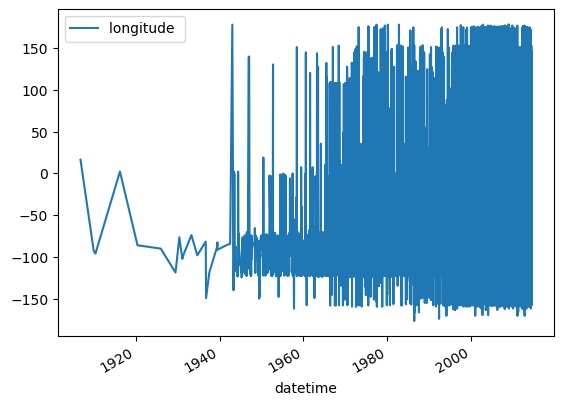

In [20]:
ufo_ts.plot()#y='duration (seconds)')

> Hmmmm.... what are we *trying* to visualize?



### What do we really want to know about UFO's? 
- Duration of sighting?
- Location of sighting?
- Number of sightings?

## Getting Our Time Series of UFO Sightings

- We want to quantify the number of events that occurred within each interval.

>- Q: How could we do this? (there's several ways)


In [21]:
## A.1) Add a count column with a value of 1 for each row and then use reasmple().sum()
demo_ts = ufo_ts.copy() 
demo_ts['Count'] = 1
demo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Count
datetime,,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1
...,...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,1
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,1
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,1


In [22]:
# A.2) 
demo_ts.resample('D').sum()#['Count']

C:\Users\Elizabeth Spreng\AppData\Local\Temp\ipykernel_22852\2363162109.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  demo_ts.resample('D').sum()#['Count']


,longitude,Count
datetime,,
1906-11-11,16.373819,1
1906-11-12,0.000000,0
1906-11-13,0.000000,0
1906-11-14,0.000000,0
1906-11-15,0.000000,0
...,...,...
2014-05-04,-711.047882,8
2014-05-05,-1277.858485,13
2014-05-06,-968.804722,12


In [23]:
## B) use .size
ufo_ts.resample("D").size()

datetime
1906-11-11     1
1906-11-12     0
1906-11-13     0
1906-11-14     0
1906-11-15     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 39261, dtype: int64

### Make `ts` from ufo_ts

In [24]:
ts = ufo_ts.resample('D').size()
ts

datetime
1906-11-11     1
1906-11-12     0
1906-11-13     0
1906-11-14     0
1906-11-15     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 39261, dtype: int64

In [25]:
plt.rcParams['figure.figsize'] = [10,5]

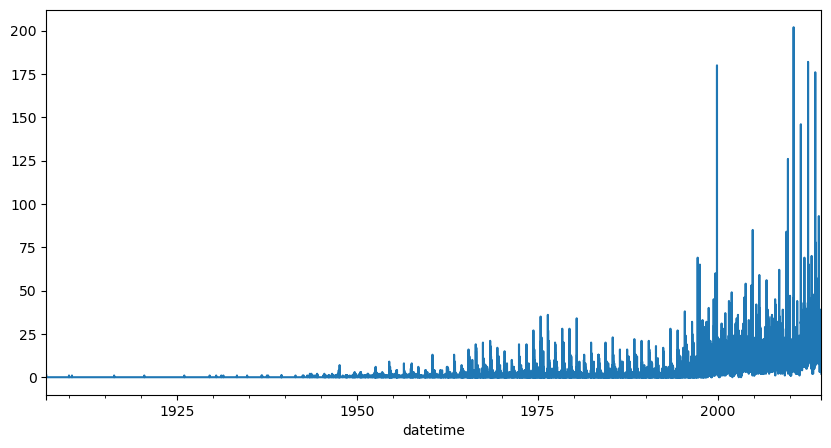

In [26]:
ts.plot();

> Let's keep data from 1950 to present day

In [27]:
ts = ts.loc["1950":]
ts

datetime
1950-01-01     0
1950-01-02     1
1950-01-03     0
1950-01-04     0
1950-01-05     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 23504, dtype: int64

<AxesSubplot: xlabel='datetime'>

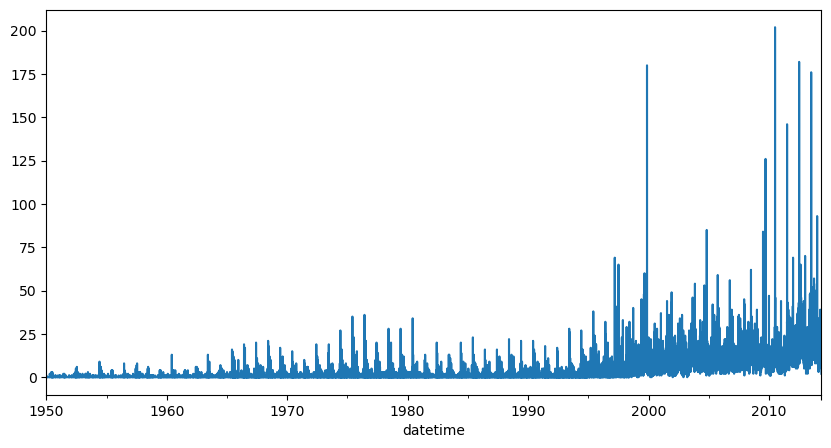

In [28]:
ts.plot()

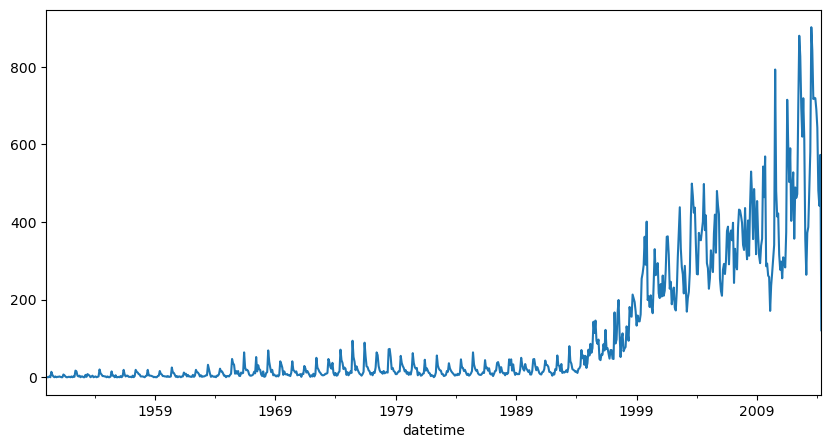

In [29]:
## save our new frequency ts and plot
ts_m = ts.resample("M").sum()
ts_m.plot();

# 🕹️Part 2) Aggregating Full Dataset Using Date Parts

## 📝 **Stakeholder Questions to Answer**

**ANSWER TOGETHER:**
- 1) What Month/Year had the most sightings? (and how many sightings were there?)

- 2) Which month of the year has the highest number of reported sightings?
- 3) Is there a seasonal pattern to UFO sightings? If so, how long is the season?

- 4) Which US holiday has the largest number of sightings?
___
**ANSWER SELECTED Q's IN BREAKOUT ROOMS**

- 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

- 6) What day of the week has the highest reported sightings?

- 7) At what time of day (hour) do most sightings occur?

- 8) Which US state has the most sightings?

- 9) Which country had the largest proportion of sightings for the year 2000?

- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes

### Making `eda_df` for answering questions

In [30]:
## making eda_df with date as a column instead of index
eda_df = ufo_ts.reset_index()
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556


### Feature Engineering: Date Parts

- Datetime objects have:
    - year
    - month
    - month_name()
    - day
    - day_name()
    - hour
    - seconds
    
- Pandas has a `.dt.` accessor to use datetime methods on an entire column at once.

In [31]:
## feature engineering for dates
eda_df['year'] = eda_df['datetime'].dt.year
eda_df['month'] = eda_df['datetime'].dt.month_name()
eda_df['day of month'] = eda_df['datetime'].dt.day
eda_df['day of week'] = eda_df['datetime'].dt.day_name()
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,October,10,Monday,20
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949,October,10,Monday,21
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955,October,10,Monday,17
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,October,10,Wednesday,21
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,October,10,Monday,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,2013,September,9,Monday,21
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,2013,September,9,Monday,22
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,2013,September,9,Monday,22
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,2013,September,9,Monday,22


> Let's add a "weekend" feature that will be True if the day was a Saturday or Sunday.

In [32]:
## let's add a weekend feature
eda_df['weekend'] = eda_df['day of week'].isin(['Saturday','Sunday'])
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,October,10,Monday,20,False
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949,October,10,Monday,21,False
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955,October,10,Monday,17,False
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,October,10,Wednesday,21,False
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,October,10,Monday,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,2013,September,9,Monday,21,False
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,2013,September,9,Monday,22,False
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,2013,September,9,Monday,22,False
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,2013,September,9,Monday,22,False


#### Let's add a column for the decade

In [33]:
## Calculate decade by subtracting the remainder and div by 10
eda_df['decade'] = eda_df['year'] - eda_df['year']%10
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend,decade
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,October,10,Monday,20,False,1940
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949,October,10,Monday,21,False,1940
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955,October,10,Monday,17,False,1950
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,October,10,Wednesday,21,False,1950
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,October,10,Monday,20,False,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,2013,September,9,Monday,21,False,2010
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,2013,September,9,Monday,22,False,2010
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,2013,September,9,Monday,22,False,2010
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,2013,September,9,Monday,22,False,2010


In [34]:
# ## Original year
# year = eda_df['year']
# year

In [35]:
# ## remainder / by 10 years
# remainder = year%10
# remainder

In [36]:
# ## Subtract to get decade
# year-remainder

## Answering Stakeholder Questions (Together)

### Making `eda_ts` & `ts`

In [37]:
## Making eda_ts with dt index
eda_ts = eda_df.set_index('datetime')

### 1) What Month/Year had the most sightings? (and how many sightings were there?)


In [38]:
## Resampling to Monthly data
ts = eda_ts.resample("M").size().loc['1950':]
ts

datetime
1950-01-31      1
1950-02-28      0
1950-03-31      0
1950-04-30      2
1950-05-31      0
             ... 
2014-01-31    643
2014-02-28    481
2014-03-31    442
2014-04-30    573
2014-05-31    121
Freq: M, Length: 773, dtype: int64

In [39]:
## resample to correct freq
ts = eda_ts.resample("M").size()

In [40]:
date_most_ufos = ts.idxmax()
date_most_ufos

Timestamp('2013-07-31 00:00:00', freq='M')

In [41]:
ts.loc[date_most_ufos]

902

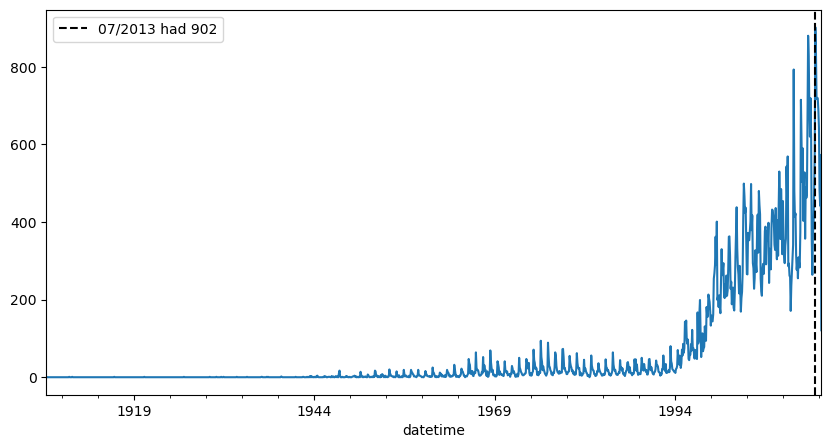

In [42]:
ax = ts.plot();
fmt = "%m/%Y"
ax.axvline(date_most_ufos, ls='--',color='k', 
           label=f"{date_most_ufos.strftime(fmt)} had {ts.loc[date_most_ufos]}")
ax.legend()

### 2) Which month of the year has the highest number of reported sightings?

In [43]:
eda_ts['month'].value_counts()

July         9520
August       8636
June         8152
September    7589
October      7407
November     6739
January      5689
December     5665
April        5527
March        5450
May          5293
February     4665
Name: month, dtype: int64


### 3) Is there a seasonal pattern to UFO sightings? If so, how long is the season?

### Seasonality

In [44]:
import statsmodels.tsa.api as tsa

In [45]:
# ts_m.loc[date_slice]
ts_check_season = ts_m.loc["2000":]
ts_check_season

datetime
2000-01-31    208
2000-02-29    181
2000-03-31    211
2000-04-30    180
2000-05-31    165
             ... 
2014-01-31    643
2014-02-28    481
2014-03-31    442
2014-04-30    573
2014-05-31    121
Freq: M, Length: 173, dtype: int64

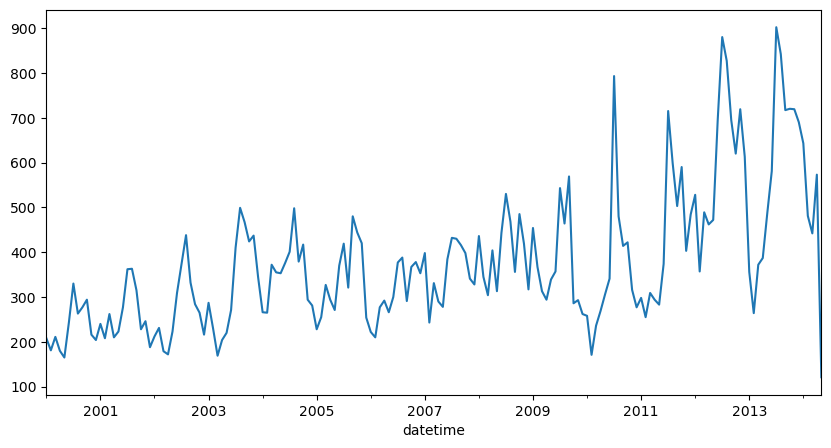

In [46]:
ts_check_season.plot();

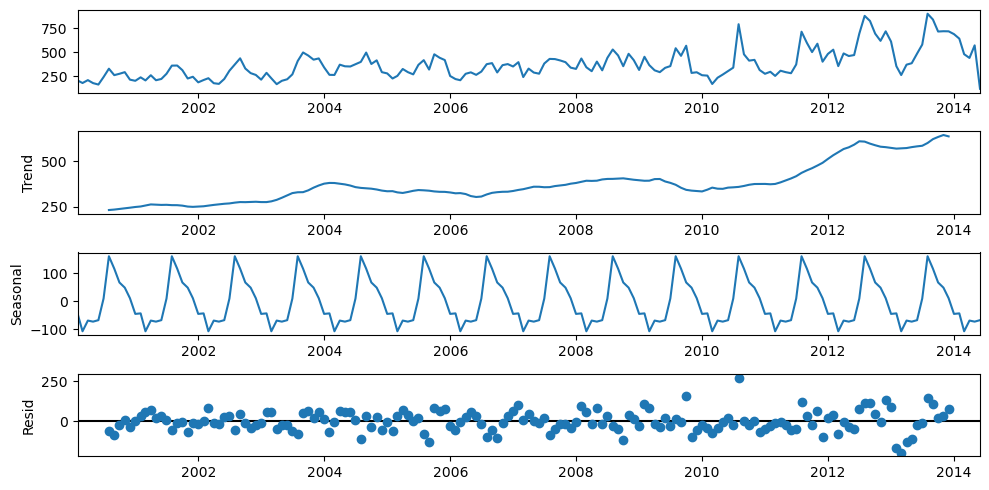

In [47]:
decomp = tsa.seasonal_decompose(ts_check_season)
decomp.plot();

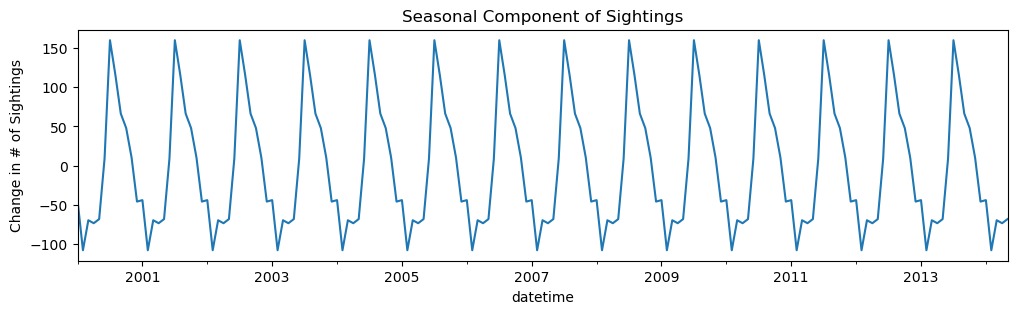

In [48]:
seasonal = decomp.seasonal
ax = seasonal.plot(figsize=(12,3))
ax.set(ylabel='Change in # of Sightings',
      title='Seasonal Component of Sightings');

#### Using scipy's find_peaks

In [49]:
from scipy.signal import find_peaks
peaks, props = find_peaks(seasonal, height=seasonal.max())

In [50]:
peaks

array([  6,  18,  30,  42,  54,  66,  78,  90, 102, 114, 126, 138, 150,
       162], dtype=int64)

In [51]:
peak_dates = seasonal.index[peaks]
peak_dates

DatetimeIndex(['2000-07-31', '2001-07-31', '2002-07-31', '2003-07-31',
               '2004-07-31', '2005-07-31', '2006-07-31', '2007-07-31',
               '2008-07-31', '2009-07-31', '2010-07-31', '2011-07-31',
               '2012-07-31', '2013-07-31'],
              dtype='datetime64[ns]', name='datetime', freq=None)

### 4) Which US holiday has the largest number of sightings?

#### Feature Engineering: Holidays

In [54]:
!pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

     -------------------------------------- 485.8/485.8 kB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB ? eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=4a221ae11faf7803ac9d655a3f803cd8fa97fcaf24b279d827329eef37670a9c
  Stored in directory: c:\users\elizabeth spreng\appdata\local\pip\cache\wheels\9b\0a\31\eb0e590d74ec13e90493cb6d1cd92a379a1a3b8f12ed778a14
Successfully built pymeeus


In [55]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [56]:
## create a test holiday 
test = "01/01/2015"
test

'01/01/2015'

In [57]:
## test the api 
us_holidays.get(test)

"New Year's Day"

In [59]:
## Saving both holiday types as columns
eda_df["US Holiday"] = eda_df['datetime'].map(us_holidays.get)
eda_df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,year,month,day of month,day of week,hour,weekend,decade,US Holiday
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,October,10,Monday,20,False,1940,None
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949,October,10,Monday,21,False,1940,None
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955,October,10,Monday,17,False,1950,None
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,October,10,Wednesday,21,False,1950,None
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,October,10,Monday,20,False,1960,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444,2013,September,9,Monday,21,False,2010,None
80328,2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500,2013,September,9,Monday,22,False,2010,None
80329,2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444,2013,September,9,Monday,22,False,2010,None
80330,2013-09-09 22:20:00,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556,2013,September,9,Monday,22,False,2010,None


In [60]:
eda_df['US Holiday'].unique()

array([None, 'Columbus Day', 'Veterans Day', 'Veterans Day (Observed)',
       "New Year's Day", 'Thanksgiving', 'Martin Luther King Jr. Day',
       "New Year's Day (Observed)", 'Christmas Day (Observed)',
       'Christmas Day', "Washington's Birthday", 'Memorial Day',
       'Independence Day (Observed)', 'Independence Day', 'Labor Day'],
      dtype=object)

#### Answer to which holiday has most sightings:

In [61]:
eda_df['US Holiday'].value_counts()

Independence Day               1208
New Year's Day                  676
Thanksgiving                    260
Christmas Day                   243
Columbus Day                    218
Veterans Day                    215
Labor Day                       198
Memorial Day                    168
Washington's Birthday           166
Martin Luther King Jr. Day      145
New Year's Day (Observed)        69
Veterans Day (Observed)          66
Independence Day (Observed)      62
Christmas Day (Observed)         52
Name: US Holiday, dtype: int64

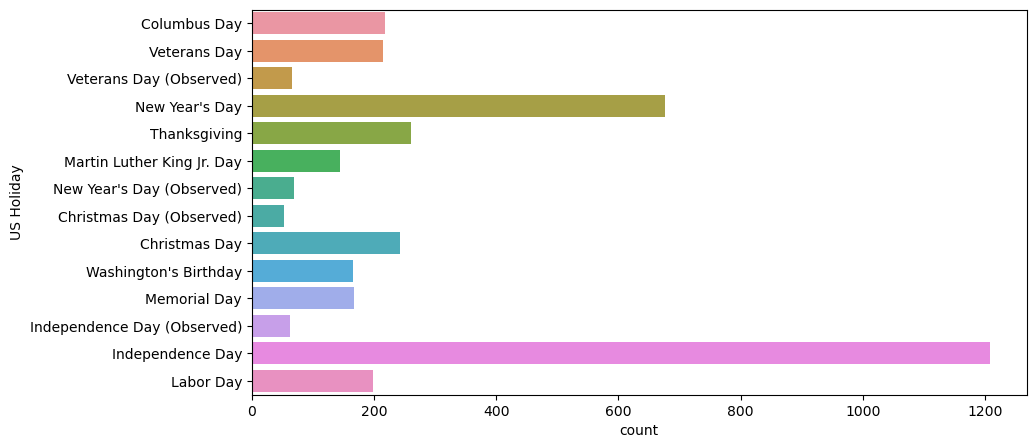

In [62]:
sns.countplot(data=eda_df, y='US Holiday');

#### Wait...when did that movie come out?

In [63]:
release_date= '1997-07-03'

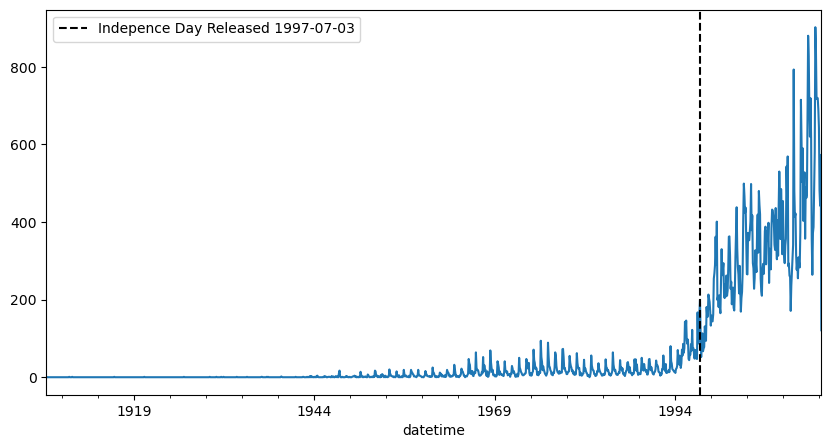

In [64]:
## Plot the # of sightings over time and annotate the release date
ax = ts.plot()
# rel_date = '1997-05-26'
ax.axvline(release_date, label=f'Indepence Day Released {release_date}',
          ls='--',color='k');
ax.legend();

## 🏓**Breakout Rooms: Answering Stakeholder Questions**

**Choose 1-2 of the remaining questions and work in breakout rooms to answer them:**
- 5) Which year had the highest % increase in sightings compared to previous years?
- 6) What day of the week has the highest reported sightings?
- 7) At what time of day (hour) do most sightings occur?
- 8) Which US state has the most sightings?
- 9) Which country had the largest proportion of sightings for the year 2000?
- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes



### 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

In [65]:
ts_a = eda_ts.resample("A").size().loc['1950':]
ts_a_pct_change = ts_a.pct_change()

In [66]:
biggest_change = ts_a_pct_change.abs().idxmax()
biggest_change

Timestamp('1995-12-31 00:00:00', freq='A-DEC')

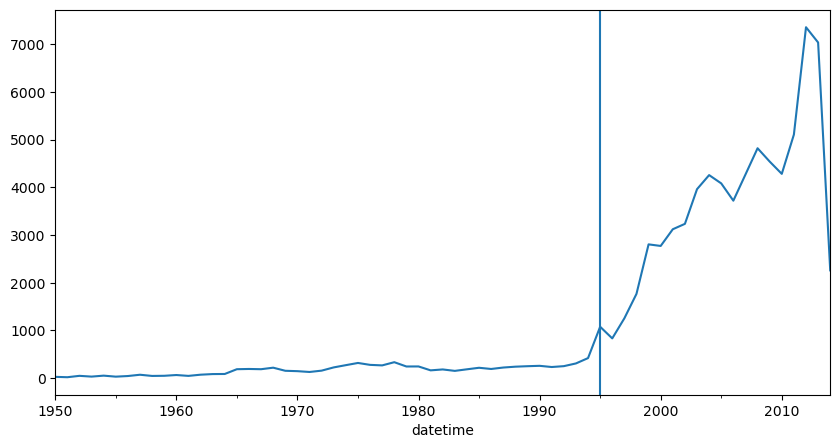

In [67]:
ax = ts_a.plot();
ax.axvline(biggest_change)

### 6) What day of the week has the highest reported sightings?

In [68]:
eda_df['day of week'].value_counts(1)

Saturday     0.175098
Sunday       0.146853
Friday       0.144475
Thursday     0.137305
Wednesday    0.136683
Tuesday      0.134305
Monday       0.125280
Name: day of week, dtype: float64

### 7) At what time of day (hour) do most sightings occur?

In [70]:
eda_df['hour'].value_counts()

21    11445
22    10837
23     8647
20     8617
19     6147
0      4108
18     4002
1      3210
17     2592
2      2357
3      2004
16     1620
5      1591
4      1529
15     1433
12     1368
14     1322
13     1303
6      1224
10     1166
11     1144
9       958
7       905
8       803
Name: hour, dtype: int64

### 8) Which US state has the most sightings?

In [71]:
eda_ts['state'].value_counts()

ca    9655
wa    4268
fl    4200
tx    3677
ny    3219
      ... 
nf      25
nt      20
pe      17
yt      13
yk       7
Name: state, Length: 67, dtype: int64

### 9) Which country had the largest proportion of sightings for the year 2000?

In [69]:
eda_ts.loc['2000','country'].value_counts()

us    2184
ca     102
gb      78
au      22
de       3
Name: country, dtype: int64

### 10) Have the types/shapes of UFO's witness changed over time?

In [72]:
eda_ts['shape'].value_counts(1)

light        0.211288
triangle     0.100319
circle       0.097041
fireball     0.079184
other        0.072054
unknown      0.071224
sphere       0.068712
disk         0.066492
oval         0.047615
formation    0.031339
cigar        0.026237
changing     0.025026
flash        0.016939
rectangle    0.016543
cylinder     0.016365
diamond      0.015026
chevron      0.012143
egg          0.009681
teardrop     0.009566
cone         0.004031
cross        0.002972
delta        0.000089
round        0.000026
crescent     0.000026
pyramid      0.000013
flare        0.000013
hexagon      0.000013
dome         0.000013
changed      0.000013
Name: shape, dtype: float64

In [ ]:
## keep only shapes that are at least 
use_shapes = eda_ts['shape'].value_counts(1).head(4).index
use_shapes

In [ ]:
ts_shapes = eda_ts.groupby('shape').resample("A").size()
ts_shapes

In [ ]:
## keeping only most common
ts_shapes = ts_shapes.unstack(0).fillna(0)[use_shapes]
ts_shapes

In [ ]:
ts_shapes = ts_shapes.loc['1980':]

In [ ]:
ts_shapes.plot()

In [ ]:
# ts_shapes.pct_change().plot()

# Bonus: Plotly Express

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.templates

### Map Over Time

In [ ]:
eda_df = eda_df.sort_values('decade')

In [ ]:
# let's use coerce - 1 row is fine to lose
eda_df['latitude'] = pd.to_numeric(eda_df['latitude'], errors='coerce')
eda_df

In [ ]:
try:
    px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade")
except Exception as e:
    display(e)

In [ ]:
eda_df.columns = eda_df.columns.str.strip()
eda_df

In [ ]:
px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade",
              template='ggplot2')